# Mapping results Nath & Thingbaijam (2012)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from openquake.hazardlib import imt

from toolbox import logspace, stdval, annotate, read_hazard_csv

In [3]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
model_path = '../Data/nath2012probabilistic'
map_table_list = [os.path.join(model_path, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [4]:
df_map = map_table_df_list[0][['lon', 'lat']]
map_csv = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
print('sites_csv = %s' % map_csv)
df_map.to_csv(map_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [5]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_inv = 1.  # year
poes_inv = 1 - np.exp(-rate*T_inv)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_inv))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_inv]))
print(poe_labels)

investigation_time = 1.0
poes = 0.002105 0.00040397
['10% in 50 years', '2% in 50 years']


In [6]:
imts = [imt.from_string(item) for item in ['PGA', 'SA(0.2)', 'SA(1.0)']]
im_levels = logspace(0.004, 5, 6)

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (str(im_type), ', '.join([str(iml) for iml in im_levels])) 
                   for im_type in imts]))

intensity_measure_types_and_levels = {"PGA": [0.0047, 0.0068000000000000005, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47000000000000003, 0.68, 1.0, 1.5, 2.2, 3.3000000000000003, 4.7], "SA(0.2)": [0.0047, 0.0068000000000000005, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47000000000000003, 0.68, 1.0, 1.5, 2.2, 3.3000000000000003, 4.7], "SA(1.0)": [0.0047, 0.0068000000000000005, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47000000000000003, 0.68, 1.0, 1.5, 2.2, 3.3000000000000003, 4.7]}


In [7]:
# areal_only_no_fmd_uncertainty_map
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 2
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_map)
print('n_sites = %d' % n_sites)
n_imt_iml = len(imts)*len(im_levels)
print('n_imt_iml = %dx%d = %d' % (len(imts),len(im_levels),n_imt_iml))
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 2
n_lt_rlzs = 7776
n_sites = 8102
n_imt_iml = 3x19 = 57
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 7776*8102*57 = 3591065664
n_files = n_lt_rlzs*n_imt_iml = 7776*57 = 443232


## Post-Processing

In [8]:
plot_cities = np.array([['Bangalore', 'Bhuj', 'Chennai'],
                        ['Guwahati', 'Jabalpur', 'Kolkata'],
                        ['Koyna', 'Mumbai', 'New Delhi']])
df_cities = pd.read_csv('../Data/nath2012probabilistic/Table 3.csv', skiprows=1, index_col='City')
# df_cities = df_cities[df_cities.index.isin(plot_cities.flatten())]
df_cities

,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
City,,,,,,,,
Ahmedabad,23.03,72.61,0.08,III,0.05,0.11,0.10,Jaiswal and Sinha 2007†
Bangalore,12.98,77.58,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
Bhuj,23.25,69.66,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
Chennai,13.00,80.18,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
Dehradun,30.33,78.04,0.12,IV,0.30,0.47,0.45,Mahajan et al. 2010
Guwahati,26.18,91.73,0.18,V,0.30,0.66,0.50,Sharma and Malik 2006
Hyderabad,17.45,78.46,0.05,II,0.05,0.09,0.08,Jaiswal and Sinha 2007†
Imphal,24.78,93.94,0.18,V,0.45,0.68,0.50,Sharma and Malik 2006
Jabalpur,23.20,79.95,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†


hazard: mean
investigation_time: 1 year
IMTs: PGA, SA(0.2), SA(1.0)
POEs: 0.002105, 0.00040397
POEs in 50 years: 10%, 1.99999%
IML limits: 0.005 g, 5 g
Grid step: 0.2°
Saving: hazard_map-mean_360.pdf


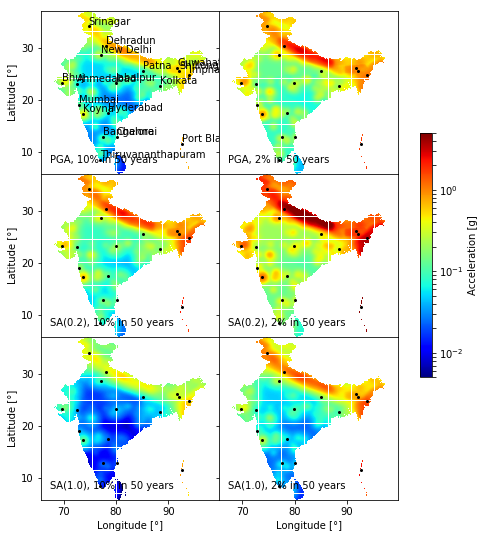

In [10]:
map_csv = './map_collapsed_v1/hazard_map-mean_360.csv'
df_calc = pd.read_csv(map_csv, header=1, index_col=['lon', 'lat'])
with open(map_csv) as file:
    hazard_type, inv_time = file.readline().split(',')
hazard_type = hazard_type.split()[1]
assert inv_time.split('=')[0].strip() == 'investigation_time'
T_inv = float(inv_time.split('=')[1])
print('hazard: ' + hazard_type)
print('investigation_time: %g year' % T_inv)

imts, poes = zip(*[item.split('-') for item in df_calc.columns])
imts = sorted(set(imts))
poes = np.array([float(item) for item in sorted(set(poes), reverse=True)])
print('IMTs: %s' % ', '.join(imts))
print('POEs: %s' % ', '.join(str(item) for item in poes))

T_nom = 50  # years
rate = -np.log(1 - poes)/T_inv
poes_nom = 1 - np.exp(-rate*T_nom)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]
print('POEs in %g years: %s' % (T_nom, ', '.join('%g%%' % (100*poe) for poe in poes_nom)))

limits = (df_calc[df_calc != 0].min().min(), df_calc.max().max())
limits = stdval(limits, 3)
print('IML limits: ' + ', '.join('%g g' % item for item in limits))

grid_step = np.mean(np.diff(sorted(list(set(df_calc.index.get_level_values('lat'))))))
print('Grid step: %g°' % grid_step)

point_size = (grid_step/0.2)**2
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_calc.index.get_level_values('lon'), 
                         df_calc.index.get_level_values('lat'), 
                         c=df_calc[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))

        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=2)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], info['Latitude (°N)']), va='bottom')

axes[0, 0].set_aspect('equal')
axes[0, 0].autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
map_pdf = os.path.splitext(os.path.basename(map_csv))[0] + '.pdf'
print('Saving: ' + map_pdf)
fig.savefig(map_pdf, dpi=300, bbox_inches='tight')

India_pga.csv renaming: {'prob10': 'PGA-0.002105', 'prob2': 'PGA-0.00040397'}
India_psa_pt2sec.csv renaming: {'prob10': 'SA(0.2)-0.002105', 'prob2': 'SA(0.2)-0.00040397'}
India_psa_1sec.csv renaming: {'prob10': 'SA(1.0)-0.002105', 'prob2': 'SA(1.0)-0.00040397'}
Saving: map_published.csv
Saving: map_published.pdf


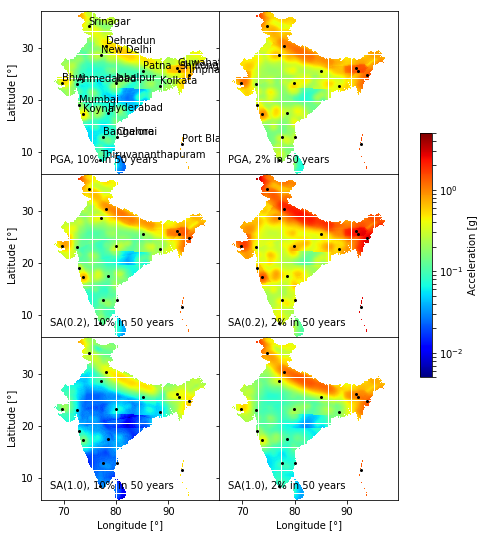

In [12]:
published_file_name = 'map_published.pdf'
model_path = '../Data/nath2012probabilistic'
map_files = ['India_pga.csv', 
             'India_psa_pt2sec.csv', 
             'India_psa_1sec.csv']
imt_rename = {'pga': 'PGA', 
              'psa_pt2sec': 'SA(0.2)', 
              'psa_1sec': 'SA(1.0)'}

dfs = []
for map_file in map_files:
    im_type = imt_rename[map_file.split('_', 1)[1].split('.')[0]]
    probs = ['prob%d' % round(100*poe_nom) for poe_nom in poes_nom]
    keys = [ '%s-%.5g' % (im_type, poe_inv) for poe_inv in poes_inv]
    rename = {prob: key for prob, key in zip(probs, keys)}
    print('%s renaming: %s' % (map_file, rename))
    df = pd.read_csv(os.path.join(model_path, map_file), index_col=['lon', 'lat'])[probs]
    df.rename(columns=rename, inplace=True)
    dfs.append(df)
df_pub = pd.concat(dfs, axis=1, sort=True)
published_csv_name = 'map_published.csv'
print('Saving: ' + published_csv_name)
df_pub.to_csv(published_csv_name)
        
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_pub.index.get_level_values('lon'), 
                         df_pub.index.get_level_values('lat'), 
                         c=df_pub[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))
        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=2)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], info['Latitude (°N)']), va='bottom')

plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
print('Saving: ' + published_file_name)
fig.savefig(published_file_name, dpi=300, bbox_inches='tight')

Saving: map_ratio.csv
Saving: map_ratio.pdf


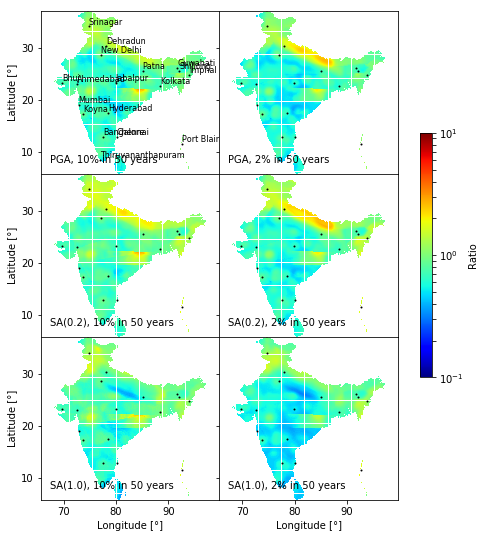

In [13]:
ratio_file_name = 'map_ratio.pdf'
df_ratio = df_calc/df_pub

ratio_csv_name = os.path.splitext(ratio_file_name)[0] + '.csv'
print('Saving: ' + ratio_csv_name)
df_ratio.to_csv(ratio_csv_name)

fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_ratio.index.get_level_values('lon'), 
                         df_ratio.index.get_level_values('lat'), 
                         c=df_ratio[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(0.1, 10))
        
        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=1)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], 
                               info['Latitude (°N)']), 
                        va='bottom', fontsize=8)

plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Ratio')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
print('Saving: ' + ratio_file_name)
fig.savefig(ratio_file_name, dpi=300, bbox_inches='tight')

In [12]:
df_cities.index

Index(['Ahmedabad', 'Bangalore', 'Bhuj', 'Chennai', 'Dehradun', 'Guwahati',
       'Hyderabad', 'Imphal', 'Jabalpur', 'Kolkata', 'Koyna', 'Mumbai',
       'New Delhi', 'Patna', 'Port Blair', 'Shillong', 'Srinagar',
       'Thiruvananthapuram'],
      dtype='object', name='City')

In [54]:
city = df_cities.loc['Srinagar']
city

Latitude (°N)     34.08
Longitude (°E)     74.8
BIS                0.18
zone                  V
GSHAP              0.25
Present            0.33
Other               NaN
Reference           NaN
Name: Srinagar, dtype: object

In [55]:
def get_near(df, city):
    delta_x = np.abs(df.index.get_level_values('lon') - city['Longitude (°E)'])
    delta_y = np.abs(df.index.get_level_values('lat') - city['Latitude (°N)'])
    index = np.where((delta_x == delta_x.min()) & (delta_y == delta_y.min()))[0][0]
    return df.iloc[index]

In [56]:
df_comparison = pd.concat((get_near(df_calc, city).round(3), 
                           get_near(df_pub, city).round(3), 
                           (100*(get_near(df_ratio, city) - 1)).round(1)), axis=1).T
df_comparison.index = ['current', 'published', 'change [%]']
df_comparison.reindex(sorted(df_comparison.columns), axis=1)
df_comparison.T

,current,published,change [%]
PGA-0.002105,0.418,0.329,27.0
PGA-0.00040397,0.775,0.650,19.2
SA(0.2)-0.002105,0.841,0.539,56.1
SA(0.2)-0.00040397,1.637,1.173,39.5
SA(1.0)-0.002105,0.345,0.288,19.8
SA(1.0)-0.00040397,0.974,0.814,19.7
